In [1]:
from IPython.display import HTML


display(HTML("<style>.container { width:" + f"{90}% " + "!important; }</style>"))


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf

import ipywidgets as widgets
from ipywidgets import interact

cf.go_offline()

# Overview
    analysis of pressure data from cell phones

# Spatial grouping
* Grid of 2.5 by 2.5 degree squares.
* Each data point was assigned to a square.
* Original data dates - May 2013 to February 2017
* This analysis is for dates between May 2013 to September 2014 only

In [3]:
df = pd.read_csv("data/pressure_count.csv.gz", index_col=[0,1]).iloc[:,4:]

# change df index from tuples of locations to strings for plotting. Save list of tuples
tup_locs = df.index
df.index = df.index.map(lambda tup: f"{tup[0]},{tup[1]}")

## World map

In [4]:
sum_loc = df.sum(axis=1)
sum_loc.index = tup_locs
sum_loc_df = sum_loc.reset_index()
sum_loc_df.columns = ["lat", "lng", "count"]


c_slider = widgets.FloatLogSlider(value=100, base=10, min=0, max=10, step=1, description="Min value")

In [5]:
# layout for map plot
grid_dict = dict(showgrid = True, gridcolor = "black", gridwidth=0.1, dtick=2.5)

geo_dict = dict(projection_type="natural earth",
                showcountries=True, countrycolor="white", showcoastlines=False, showrivers=True, showframe=False,
                showland=True, landcolor="#c2c2c2", showocean=True, oceancolor="#e6fcfc",
                showlakes=True, lakecolor="#3399FF", lonaxis=grid_dict, lataxis=grid_dict)

colorbar_dict = dict(thicknessmode="fraction", thickness=0.01, xpad=0)
coloraxis={"colorbar": colorbar_dict, "colorscale": "jet"}
margin={"l":0, "b":0, "t":50}


scatter_geo_layout = go.Layout(coloraxis=coloraxis, margin=margin, geo=geo_dict)

In [6]:
@interact

def show_sum_loc_map(min_val=c_slider):
    
    sum_loc_filter = sum_loc_df[sum_loc_df["count"] > min_val]
    
    fig = px.scatter_geo(sum_loc_filter, lat="lat", lon="lng", color="count")
    fig.update_layout(scatter_geo_layout, title="Count of pressure data points - world map")
    fig.show()

interactive(children=(FloatLogSlider(value=100.0, description='Min value', max=10.0, step=1.0), Output()), _do…

## Histogram

In [7]:
@interact

def show_sum_loc(min_val=c_slider):
    
    sum_loc[sum_loc > min_val].iplot(kind="bar", title="Count of pressure data points - histogram", 
                                     xTitle="Location", yTitle="Count")

interactive(children=(FloatLogSlider(value=100.0, description='Min value', max=10.0, step=1.0), Output()), _do…

## Heatmap

In [8]:
@interact

def show_sum_loc_date(log_scale=True, dropna=False, inverted_colorscale=False, 
                      colorscale=["rdylgn", "gnbu", "purples", "rdbu"]):
    
    if log_scale:
        df_to_plot = np.log10(df)
    
    else:
        df_to_plot = df
        
    if dropna:
        df_to_plot = df_to_plot.dropna()
        
    if inverted_colorscale:
        cs = f"-{colorscale}"
    else:
        cs = colorscale
    
    df_to_plot.T.iplot(kind="heatmap", colorscale=cs, 
                     title="Count of pressure data points - heatmap location vs month",
                     xTitle="Date", yTitle="Location")

interactive(children=(Checkbox(value=True, description='log_scale'), Checkbox(value=False, description='dropna…

## Histogram - by month

In [9]:
df.sum().iplot(kind="bar", title="Pressure data points - count by month", 
               xTitle="Month", yTitle="Count")

# Computing FFT
* Goal: find out if cell phone data can recreate typical phenomena
* In order to compute FFT, we need a time series with evenly spaced points
* For every location, construct a time series of hourly pressure mean value

## Pre processing

**1. Clean outliers**

   - Based on z score. 
   - Every data point more than **5** standard deviations away from the mean pressure was removed.
    
*Example:* for location: latitude: 50, longitude: -5
    
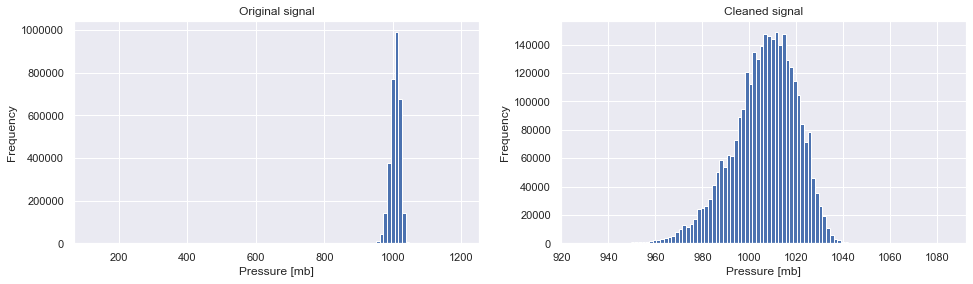

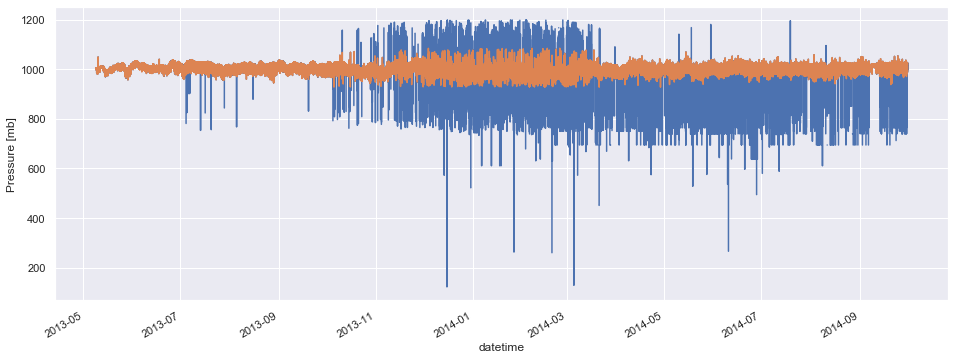

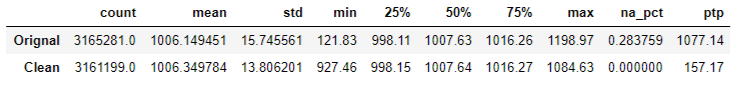

**2. Group by hours**

   - For every hour compute its mean pressure
    
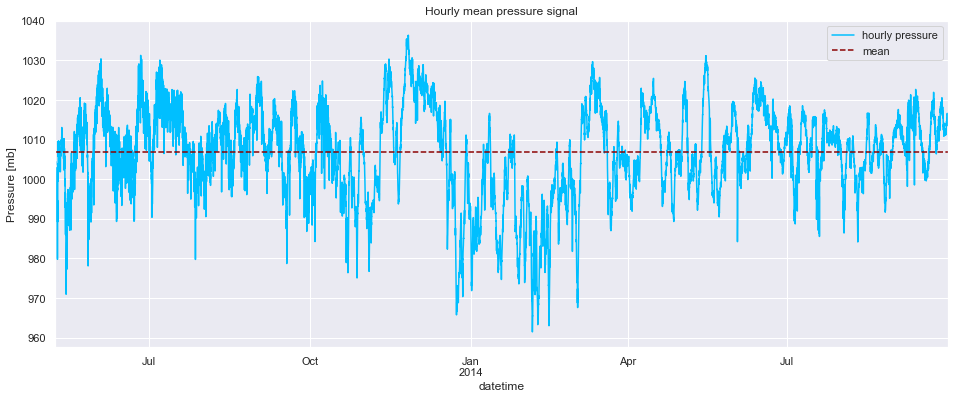

**3. Fill missing values**
* Hours with no data were filled with mean value of the hourly signal constructed by groupby

**4. Standardize signal**
* Use z score to standardize signal
* This is done to make data comparable with white noise, normally distributed around 0 with standard deviation of 1

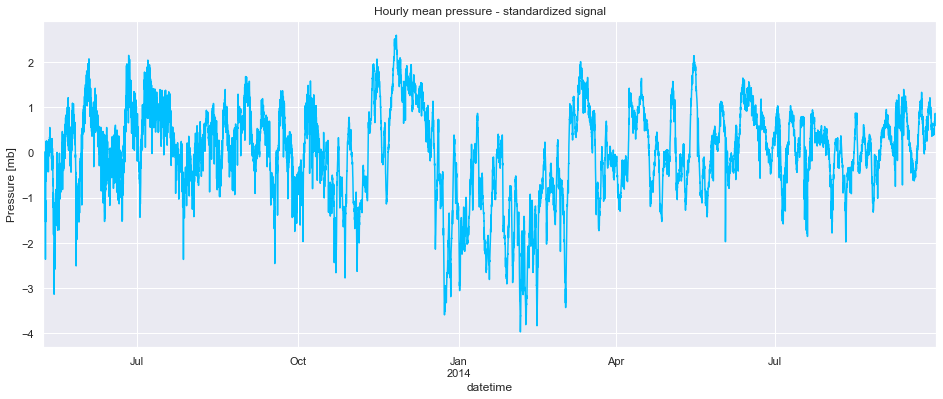